In [36]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import seaborn as sns
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [20]:
# vars for where zmaps are stored
INPUT_DIR = '/home/users/nklevak/network_data/'
os.makedirs(INPUT_DIR, exist_ok=True)

# relevant task and contrast data
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

max_num_encounters = 5

In [21]:
# load the zmaps
def load_zmaps_with_metadata(input_dir):
    """
    Load z-statistic maps and their metadata from a BIDS-like directory structure.
    
    Parameters:
    -----------
    input_dir : str
        Directory where files were saved.
        
    Returns:
    --------
    dict
        Nested dictionary containing loaded zmaps and metadata, organized by task, contrast, and encounter.
    """
    # Initialize nested defaultdict to store the loaded data
    loaded_data = defaultdict(lambda: defaultdict(dict))
    
    # Track number of files loaded
    num_files_loaded = 0
    
    # Walk through the directory structure
    for task_name in os.listdir(input_dir):
        task_dir = os.path.join(input_dir, task_name)
        
        # Skip if not a directory
        if not os.path.isdir(task_dir):
            continue
            
        for contrast_name in os.listdir(task_dir):
            contrast_dir = os.path.join(task_dir, contrast_name)
            
            # Skip if not a directory
            if not os.path.isdir(contrast_dir):
                continue
                
            # Find all .nii.gz files in this contrast directory
            for filename in os.listdir(contrast_dir):
                if filename.endswith('.nii.gz'):
                    # Extract base filename without extension
                    base_filename = filename.replace('.nii.gz', '')
                    
                    # Check if corresponding JSON metadata exists
                    json_path = os.path.join(contrast_dir, f"{base_filename}.json")
                    if not os.path.exists(json_path):
                        print(f"Warning: No metadata found for {filename}")
                        continue
                    
                    # Load the image
                    img_path = os.path.join(contrast_dir, filename)
                    zmap = nib.load(img_path)
                    
                    # Load the metadata
                    with open(json_path, 'r') as f:
                        metadata = json.load(f)
                    
                    # Get encounter index (0-based)
                    encounter_idx = metadata["EncounterNumber"] - 1
                    
                    # Store both the image and metadata
                    loaded_data[task_name][contrast_name][encounter_idx] = {
                        'zmap': zmap,
                        'metadata': metadata
                    }
                    
                    num_files_loaded += 1
    
    print(f"Loaded {num_files_loaded} z-statistic maps with metadata.")
    return loaded_data

In [22]:
loaded_zmaps = load_zmaps_with_metadata(INPUT_DIR)

Loaded 211 z-statistic maps with metadata.


In [27]:
def gatherRelevantMaps(all_maps, req_tasks, req_contrasts, req_encounters):
    
    descriptors = [] #where we will insert the string name of the each included map
    rel_zmaps = []
    
    for task in req_tasks:
        if task not in TASKS:
            continue
    
        for contrast in req_contrasts[task]:
            if contrast not in CONTRASTS[task]:
                continue
    
            for encounter in req_encounters:
                if encounter < 0 or encounter >= max_num_encounters:
                    continue
    
                if (len(req_tasks) > 1):
                    descriptor_name = f"{task}:{contrast}:encounter-0{encounter + 1}"
                else:
                    descriptor_name = f"t:{contrast}:encounter-0{encounter + 1}"

                if task in all_maps.keys():
                    if contrast in all_maps[task].keys():
                        if encounter in all_maps[task][contrast].keys():
                            map = all_maps[task][contrast][encounter]["zmap"]

                            rel_zmaps.append(map)
                            descriptors.append(descriptor_name)
                        else:
                            print(f"{encounter} is not in zmap for {task},{contrast}")
                            continue
                    else:
                        print(f"{contrast} is not in zmap for {task}")
                        continue
                else:
                    print(f"{task} is not in zmap")
                    continue
    
    return rel_zmaps, descriptors

In [28]:
requested_tasks = TASKS
requested_contrasts = CONTRASTS # all of the contrasts
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)

4 is not in zmap for goNogo,nogo_success-go
4 is not in zmap for goNogo,nogo_success
4 is not in zmap for goNogo,task-baseline
4 is not in zmap for goNogo,response_time


## Masking to focus on specific networks before calculating correlations between sessions / contrasts / tasks

In [37]:
# download Yeo atlas
yeo = datasets.fetch_atlas_yeo_2011()
yeo_7network = yeo['thick_7'] 

network_names = {
    1: "Visual",
    2: "Somatomotor",
    3: "Dorsal Attention",
    4: "Ventral Attention",
    5: "Limbic",
    6: "Frontoparietal Control",
    7: "Default Mode"
}

zmaps_loaded = rel_zmaps # already NIFTI images
reference_map = zmaps_loaded[0]
# make the Yeo atlas be in the same space
yeo_resampled = image.resample_to_img(yeo_7network, reference_map, interpolation='nearest')

[get_dataset_dir] Dataset found in /home/users/nklevak/nilearn_data/yeo_2011

/tmp/ipykernel_26017/1497568342.py:18: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  yeo_resampled = image.resample_to_img(yeo_7network, reference_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [39]:
def get_yeo_network_corrs(zmaps, desc_list, yeo_img = yeo_resampled):
    """
    Calculate correlations between zmaps within each Yeo network.
    
    Parameters:
    -----------
    zmaps : list
        List of zmaps (NIfTI images)
    desc_list : list
        List of descriptions for each zmap (e.g., "task:contrast:encounter")
    yeo_img : NIfTI image
        Yeo atlas image
        
    Returns:
    --------
    dict
        Dictionary with results for each network
    """
    
    # go through each Yeo network and calculate correlations between relevant tasks/contrasts/encounters
    network_results = {}
    for network_id in range(1, 8):
        # Create mask for this network
        network_mask = image.math_img(f'img == {network_id}', img=yeo_img)
        
        # Extract data for all sessions within this network
        network_data = []
        for zmap in zmaps:
            masked_data = masking.apply_mask(zmap, network_mask)
            network_data.append(masked_data)
        
        # Convert to array
        data_array = np.array(network_data)
        
        if data_array.shape[1] > 1:
            # Calculate correlation matrix between all sessions
            corr_matrix = np.corrcoef(data_array)
            
            # Store results
            network_results[network_names[network_id]] = {
                'correlation_matrix': corr_matrix,
                'mean_correlation': np.mean(np.triu(corr_matrix, k=1)),
                'voxel_count': data_array.shape[1],
                'descriptions': desc_list
            }
        else:
            network_results[network_names[network_id]] = {
                'correlation_matrix': np.array([]),
                'mean_correlation': np.nan,
                'voxel_count': data_array.shape[1],
                'descriptions': desc_list
            }
    return network_results

In [40]:
def plot_network_correlations(network_results, network_name):
    """
    Plot correlation matrix for a specific network with proper labels.
    
    Parameters:
    -----------
    network_results : dict
        Results from get_yeo_network_corrs function
    network_name : str
        Name of the network to plot (e.g., "Frontoparietal Control")
    """
    if network_name not in network_results:
        print(f"Network {network_name} not found in results")
        return
    
    result = network_results[network_name]
    
    if result['correlation_matrix'].size == 0:
        print(f"No correlation data available for {network_name} network")
        return
    
    # Get correlation matrix and descriptions
    corr_matrix = result['correlation_matrix']
    labels = result['descriptions']
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, 
                annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.title(f"Correlations in {network_name} Network")
    plt.tight_layout()
    
    return plt.gcf()  # Return the figure for further customization if needed

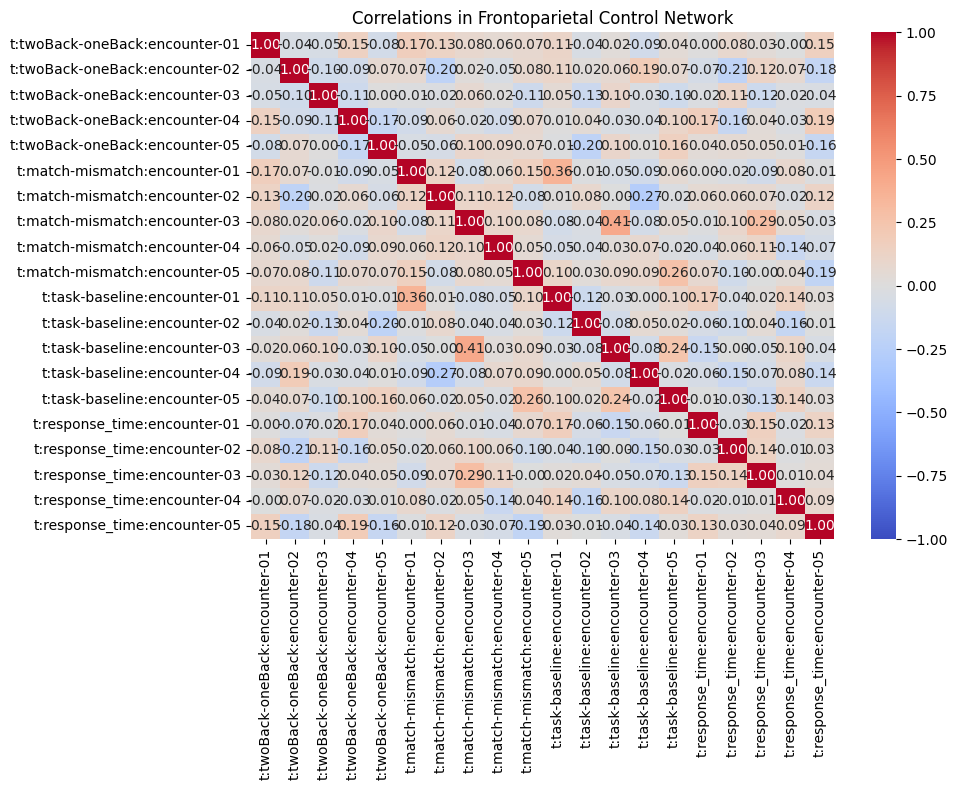

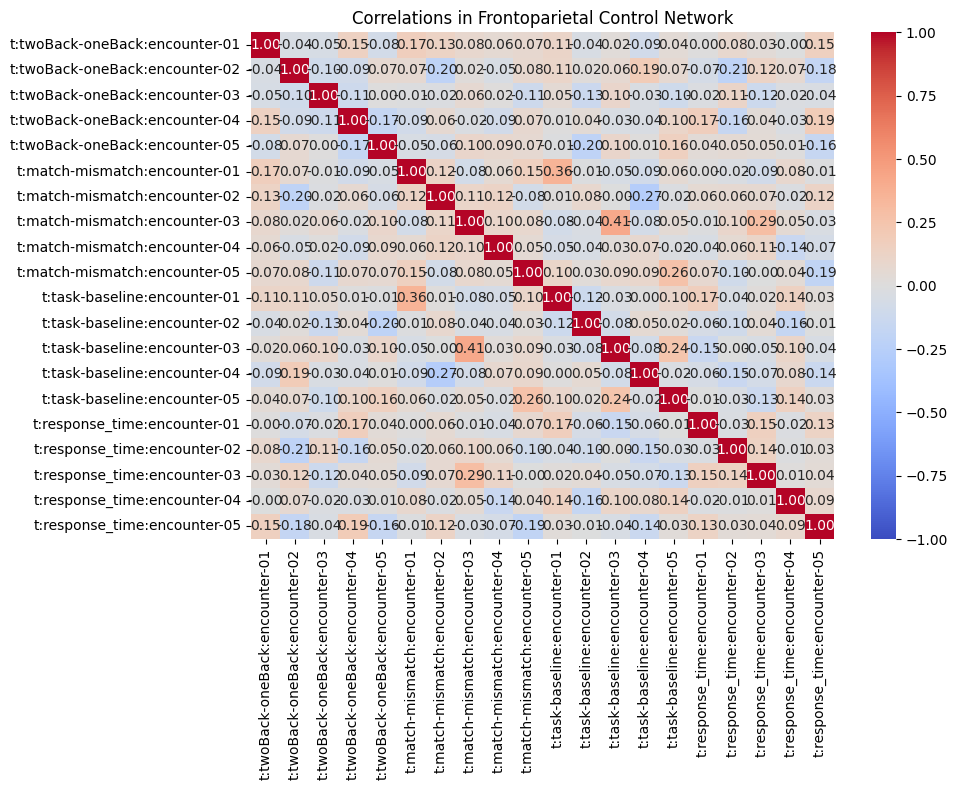

In [42]:
# TEST: run this with nBack
requested_tasks = ["nBack"]
requested_contrasts = {}
requested_contrasts["nBack"] = CONTRASTS["nBack"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
zmaps_nBack, desc_list_nBack = gatherRelevantMaps(loaded_zmaps, requested_tasks, requested_contrasts, requested_encounters)
net_results = get_yeo_network_corrs(zmaps_nBack, desc_list_nBack, yeo_img = yeo_resampled)
plot_network_correlations(net_results, network_names[6])